Packages importations

In [2]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pathlib
import io
from datetime import datetime
import json
import xml.etree.ElementTree as ET
import os
import shutil
import cv2
import time
import random
from PIL import Image
import albumentations as A
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape, LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal

Verify the version of tf

In [4]:
print(tf.__version__)

2.15.0


Images and annotations

In [5]:
train_images = "JPEGImages/"
train_maps = "Annotations/"

val_images= "ValJPEGImages/"
val_maps= "ValAnnotations/"

Classes of the Pascal VOC dataset

In [6]:
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

Hyperparameters

In [7]:
# HYPERPARAMETERS
B = 2
N_CLASSES = len(classes)
OBJ_INDICATORS = N_CLASSES + 5*B
H, W = 224, 224
SPLIT_SIZE = H//32
EPOCHS = 135
LR = 5e-4
CHANNELS = 3
NUM_FILTERS = 512
BATCH_SIZE=32
OUTPUT_DIM = N_CLASSES + 5*B

Images that will be used for the validation during training time

In [8]:
val_list=['2007_000027.jpg','2007_000032.jpg','2007_000033.jpg','2007_000039.jpg','2007_000042.jpg','2007_000061.jpg',
          '2007_000063.jpg','2007_000068.jpg','2007_000121.jpg','2007_000123.jpg','2007_000129.jpg','2007_000170.jpg',
          '2007_000175.jpg','2007_000187.jpg','2007_000241.jpg','2007_000243.jpg','2007_000250.jpg','2007_000256.jpg',
          '2007_000272.jpg','2007_000323.jpg','2007_000332.jpg','2007_000333.jpg','2007_000346.jpg','2007_000363.jpg',
          '2007_000364.jpg','2007_000392.jpg','2007_000423.jpg','2007_000452.jpg','2007_000464.jpg','2007_000480.jpg',
          '2007_000491.jpg','2007_000504.jpg','2007_000515.jpg','2007_000528.jpg','2007_000529.jpg','2007_000549.jpg',
          '2007_000559.jpg','2007_000572.jpg','2007_000584.jpg','2007_000629.jpg','2007_000636.jpg','2007_000645.jpg',
          '2007_000648.jpg','2007_000661.jpg','2007_000663.jpg','2007_000664.jpg','2007_000676.jpg','2007_000713.jpg',
          '2007_000720.jpg','2007_000727.jpg','2007_000733.jpg','2007_000738.jpg','2007_000762.jpg','2007_000768.jpg',
          '2007_000783.jpg','2007_000793.jpg','2007_000799.jpg','2007_000804.jpg','2007_000807.jpg','2007_000822.jpg',
          '2007_001299.jpg','2007_001311.jpg','2007_001321.jpg','2007_001340.jpg']

In [9]:
## TO DO just once
#for name in val_list:
#    shutil.move(train_maps+name[:-3]+"xml", val_maps+name[:-3]+"xml")

In [10]:
## TO DO just once
#for name in val_list:
#  shutil.move(train_images+name, val_images+name)

Processing the annotations inside the XML files

In [11]:
def preprocess_xml(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    size_tree = root.find("size")
    # get the height and width of the images
    width = float(size_tree.find("width").text)
    height = float(size_tree.find("height").text)
    # add the depth of the image
    #depth = float(size_tree.find("depth").text)
    #print(f"Height of the image: {height}") 
    #print(f"width of the image: {width}")
    #print(f"Depth of the image: {depth}")

    bounding_boxes= []
    # Find the objects in the file
    for object_tree in root.findall("object"): 
        # Find the boundboxes in the objects
        for bounding_box in object_tree.findall("bndbox"):
            # Get the coordinates of the bounding box
            x_min = (float(bounding_box.find("xmin").text))
            y_min = (float(bounding_box.find("ymin").text))
            x_max = (float(bounding_box.find("xmax").text))
            y_max = (float(bounding_box.find("ymax").text))
            #print(x_min, x_max, y_min, y_max)
            break

        # Get the label of the object
        class_name = object_tree.find("name").text
        # One-Hot encoding the classes
        class_dict={classes[i]:i for i in range(len(classes))}
        
        # Normalize the bounding box coordinates
        bounding_box = [
        # Center divided by the width
        (x_min+x_max)/(2*width),
        # Center divided by the height
        (y_min+y_max)/(2*height),
        # Width of the box divided by the width of the image
        (x_max-x_min)/width,
        # Height of the box divided by the height of the image
        (y_max-y_min)/height,
        # Label of the object encoded as a one-hot vector
        class_dict[class_name]]

        bounding_boxes.append(bounding_box)
    
    return tf.convert_to_tensor(bounding_boxes)

Test the preprocessing of an XML file

In [12]:
preprocess_xml(val_maps + "2007_000032.xml")

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.479     ,  0.4644128 ,  0.542     ,  0.37366548,  0.        ],
       [ 0.33      ,  0.37544483,  0.128     ,  0.12455516,  0.        ],
       [ 0.408     ,  0.727758  ,  0.036     ,  0.17437722, 14.        ],
       [ 0.07      ,  0.7597865 ,  0.036     ,  0.17437722, 14.        ]],
      dtype=float32)>

Generate the output of the labels

In [14]:
def generate_output(bounding_boxes):
    '''
        Generate the presence of an object
        + bounding boxes coordinates + class of the object recognized
        in a 30 numerical values form
    '''
    # Initialize the output tensor
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES+5))

    for b in range(len(bounding_boxes)):
        # Origin of the grid where an object is detected
        grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
        # Origin of the grid where an object is detected
        grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE

        # Coordiantes of the grid where the center of an object is detected
        i = int(grid_x)
        j = int(grid_y)

        # Assign the presence of an object + coordinates of the bouding box
        output_label[i, j, 0:5]=[1.,grid_x%1, grid_y%1, bounding_boxes[..., b, 2],bounding_boxes[..., b, 3]]
        # Assign the calss of the object detected
        output_label[i, j, 5+int(bounding_boxes[...,b,4])] = 1.
    
    return tf.convert_to_tensor(output_label, tf.float32)

Visualize the image with the 7x7 grid (YOLO model works like that)

In [15]:
def visualize_grid(image):

    # Add a grid to the image
    height, width = image.shape[:2]
    rows = 7
    cols = 7

    # Calculate grid line spacing
    row_step = height // rows
    col_step = width // cols

    # Draw horizontal grid lines
    for i in range(1, rows):
        y = i * row_step
        cv2.line(image, (0, y), (width, y), (0, 255, 0), 2)  # Green lines

    # Draw vertical grid lines
    for j in range(1, cols):
        x = j * col_step
        cv2.line(image, (x, 0), (x, height), (0, 255, 0), 2)


    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

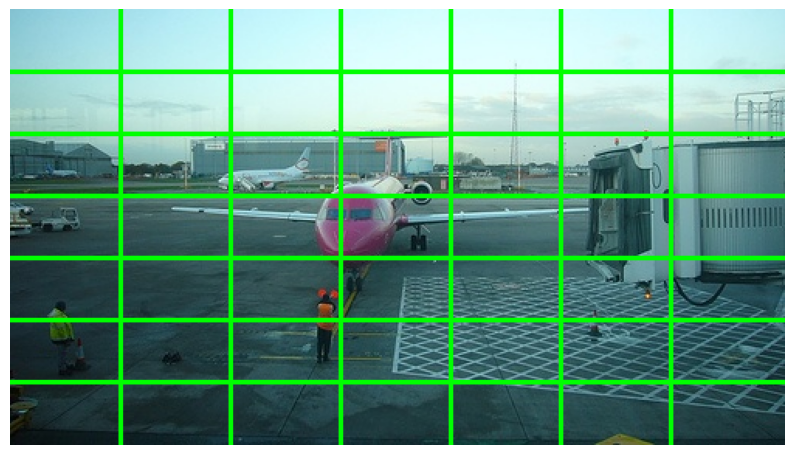

In [16]:
image = cv2.imread(val_images+"2007_000032.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize_grid(image)

In this picture we have the center of an object at position:
- Person: 0, 5
- Plane: 3, 3
- Person: 2, 5
- Plane: 2. 2

In [21]:
# The output when an object is detected
#generate_output(preprocess_xml(val_maps+"2007_000032.xml"),)[3][3]
#generate_output(preprocess_xml(val_maps+"2007_000032.xml"),)[0][5]
#generate_output(preprocess_xml(val_maps+"2007_000032.xml"),)[2][5]
#generate_output(preprocess_xml(val_maps+"2007_000032.xml"),)[2][2]

Number of training and validation images

In [22]:
train_img_paths = []
train_xml_paths = []

val_im_paths = []
val_xml_paths = []


for i in os.listdir(train_maps):
  
  train_img_paths.append(train_images+i[:-3]+'jpg')
  train_xml_paths.append(train_maps+i)
  
for i in os.listdir(val_maps):
  
  val_im_paths.append(val_images+i[:-3]+'jpg')
  val_xml_paths.append(val_maps+i)
  
print(len(train_img_paths),len(train_xml_paths))
print(len(val_im_paths),len(val_xml_paths))

17061 17061
64 64


Dataset creation

In [23]:
# Create the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_paths,train_xml_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_im_paths,val_xml_paths))

In [24]:
# Take one example in the validation dataset
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'ValJPEGImages/2007_000027.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'ValAnnotations/2007_000027.xml'>)


Get the coordinates of the boxes for images

In [25]:
def get_imbboxes(im_path, xml_path):
  # Decode the jpeg file 
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  # Resize and cast the file 
  img = tf.cast(tf.image.resize(img, [H,W]),dtype=tf.float32)

  bboxes = tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)
  return img, bboxes

In [26]:
train_dataset = train_dataset.map(get_imbboxes)
val_dataset = val_dataset.map(get_imbboxes)

In [28]:
for i,j in train_dataset.take(1):
  print(i.shape,j)
  break

(224, 224, 3) tf.Tensor(
[[ 0.476       0.736       0.456       0.50133336 10.        ]
 [ 0.409       0.79466665  0.218       0.41066667  8.        ]
 [ 0.6         0.73066664  0.192       0.38933334  8.        ]
 [ 0.568       0.564       0.136       0.19466667  8.        ]], shape=(4, 5), dtype=float32)


In [30]:
cv2.imwrite('out_1.jpg',np.array(i))

True

In [31]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

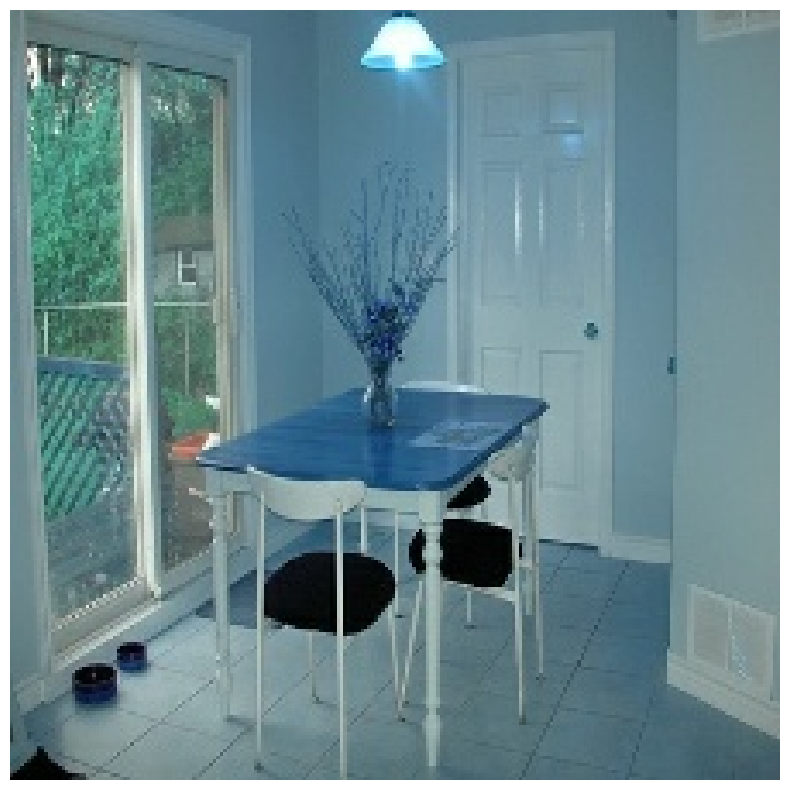

In [32]:
image = cv2.imread("out_1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

Create an albumentation pipeline to augment the images

In [34]:
transforms = A.Compose([
    A.Resize(H,W),
    A.RandomCrop(
         width=np.random.randint(int(0.9*W),W),
         height=np.random.randint(int(0.9*H),H), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4,p=0.5),
    A.HorizontalFlip(p=0.5,),
    A.Resize(H,W),
    
], bbox_params=A.BboxParams(format='yolo', ))

In [35]:
def aug_albument(image,bboxes):
  augmented=transforms(image=image,bboxes=bboxes)
  return [
    tf.convert_to_tensor(augmented["image"], dtype=tf.float32),
    tf.convert_to_tensor(augmented["bboxes"], dtype=tf.float32)
    ]

In [36]:
def process_data(image,bboxes):
    # Augment the data
    aug = tf.numpy_function(func=aug_albument, inp=[image,bboxes], Tout=(tf.float32,tf.float32))
    
    return aug[0], aug[1]

In [37]:
train_dataset=train_dataset.map(process_data)

In [38]:
for i,j in train_dataset.take(1):
  print(i.shape,j)
  break

(224, 224, 3) tf.Tensor(
[[ 0.4787573   0.73312104  0.49584466  0.53375787 10.        ]
 [ 0.40590292  0.7910713   0.23704854  0.4178574   8.        ]
 [ 0.61359227  0.7396484   0.2087767   0.4338839   8.        ]
 [ 0.57879615  0.55391043  0.1478835   0.21694195  8.        ]], shape=(4, 5), dtype=float32)


In [39]:
cv2.imwrite('out_2.jpg',np.array(i))

True

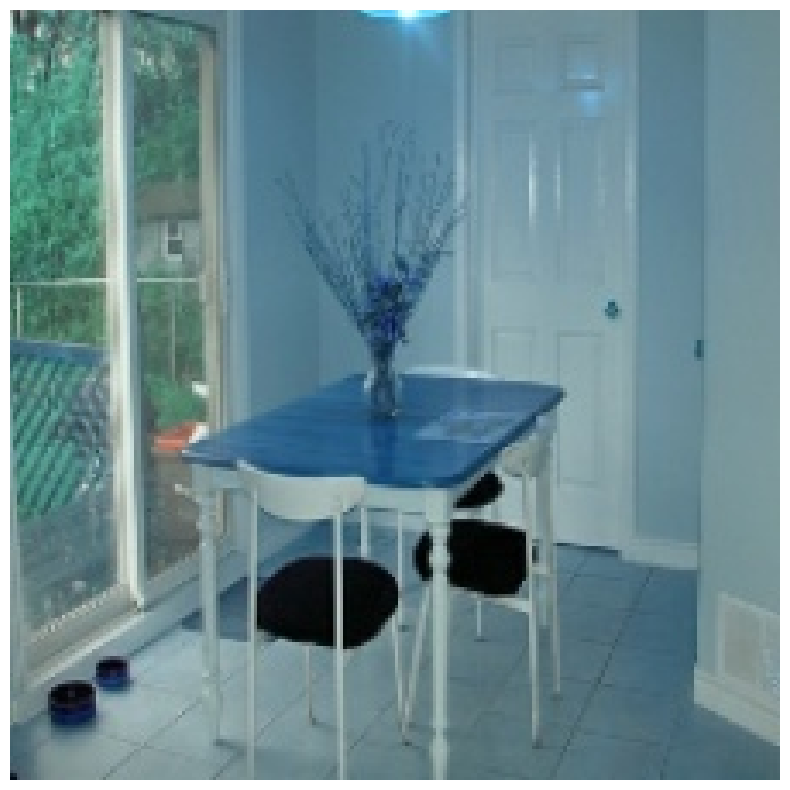

In [40]:
image = cv2.imread("out_2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

Augmentation application

In [41]:
def preprocess_augment(img,y):
  img = tf.image.random_brightness(img, max_delta=50.)
  img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
  img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
  #img = tf.image.random_hue(img, max_delta=0.5 )
  img = tf.clip_by_value(img, 0, 255)
  labels=tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  
  return img,labels

Preprocessing of the images

In [42]:
def preprocess(img,y):
  img = tf.cast(tf.image.resize(img, size=[H, W]), dtype=tf.float32)

  labels = tf.numpy_function(func=generate_output, inp=[y], Tout=(tf.float32))
  
  return img, labels

In [43]:
train_dataset = train_dataset.map(preprocess_augment)
val_dataset = val_dataset.map(preprocess)

In [44]:
train_dataset=(
  train_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [45]:
val_dataset=(
  val_dataset.
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

In [46]:
for i,j in train_dataset.take(1):
  print(i.shape,j)
  break

(32, 224, 224, 3) tf.Tensor(
[[[[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.  

In [50]:
cv2.imwrite('out_3.jpg',np.array(i[2]))

True

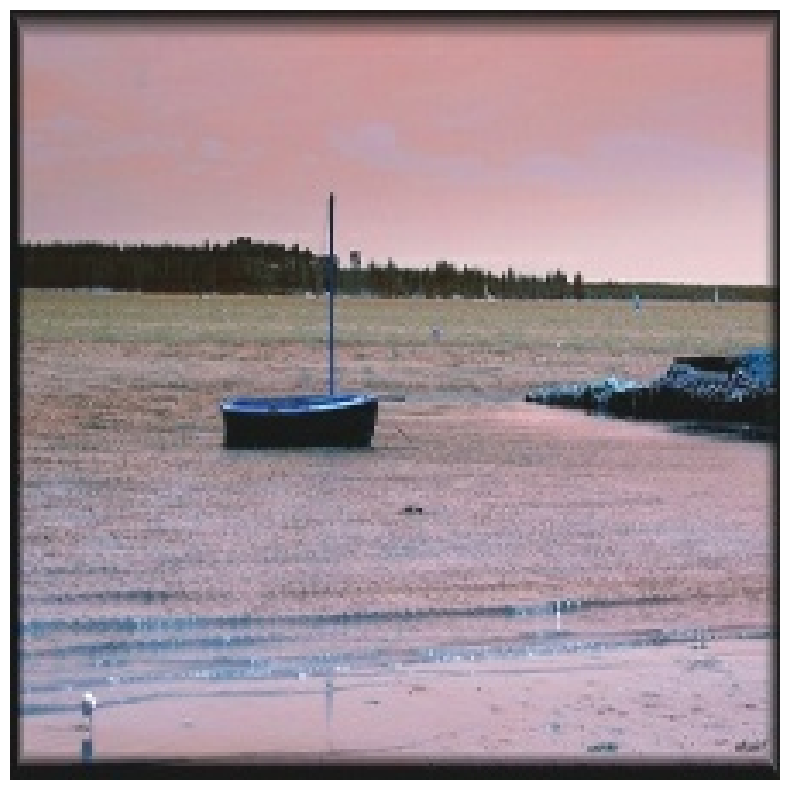

In [51]:
image = cv2.imread("out_3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

Base model EfficientNetB1

In [52]:
base_model=tf.keras.applications.efficientnet.EfficientNetB1(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
# Freeze all the layers
base_model.trainable=False

In [53]:
#conv_base.summary()

In [54]:
model=tf.keras.Sequential([    
  base_model,
  Conv2D(NUM_FILTERS,(3,3), padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Conv2D(NUM_FILTERS,(3,3),padding = 'same',kernel_initializer='he_normal',),
  LeakyReLU(alpha=0.1),

  Flatten(),
  
  Dense(NUM_FILTERS,kernel_initializer='he_normal',),
  BatchNormalization(),
  LeakyReLU(alpha=0.1),
  
  Dropout(0.5),
  
  Dense(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM,activation='sigmoid'),
  
  Reshape((SPLIT_SIZE,SPLIT_SIZE,OUTPUT_DIM)),
])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         5898752   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 512)         2

Create the IOU metric (Intersection Over Union)

In [56]:
def compute_iou(boxes1, boxes2):
    # Convert boxes to tensor
    boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0,
                         boxes1[..., 1] - boxes1[..., 3] / 2.0,
                         boxes1[..., 0] + boxes1[..., 2] / 2.0,
                         boxes1[..., 1] + boxes1[..., 3] / 2.0],
                        axis=-1)

    boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                         boxes2[..., 1] - boxes2[..., 3] / 2.0,
                         boxes2[..., 0] + boxes2[..., 2] / 2.0,
                         boxes2[..., 1] + boxes2[..., 3] / 2.0],
                        axis=-1)
    
    # Calculate intersection over union
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)
    
    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)

In [63]:
def difference(x, y):
  return tf.reduce_sum(tf.square(y-x))

In [57]:
# The loss function has 4 different parts:
    # 1. Coordinates loss
    # 2. Objectness loss
    # 3. Non objectness loss
    # 4. Classification loss

def yolo_loss(y_true, y_pred):
  target = y_true[...,0]

  # Object loss
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:]==1))
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:]==1))
  
  rescaler = tf.where(target[:]==1)*SPLIT_SIZE
  upscaler_1 = tf.concat([rescaler[:,1:],tf.zeros([len(rescaler),2], dtype=tf.int64)],axis=-1)
  
  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[len(rescaler)], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[len(rescaler)], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)
  
  target_orig = tf.cast(upscaler_1, dtype = tf.float32)+target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32)+pred_2_upscaler_2
  
  mask =tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)
  
  y_pred_joined=tf.transpose(tf.concat([tf.expand_dims(y_pred_extract[...,0],axis=0),
                        tf.expand_dims(y_pred_extract[...,5],axis=0)],axis=0))
  
  obj_pred = tf.gather_nd(y_pred_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  
  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([len(rescaler)]),dtype=tf.float32))

  # For no object loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==0))
  y_target_extract = tf.zeros(len(y_pred_extract))

  no_object_loss_1 = difference(tf.cast(y_pred_extract[...,0],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))
  
  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5],dtype =tf.float32)
                            ,tf.cast(y_target_extract,dtype=tf.float32))
  
  no_object_loss = no_object_loss_1+no_object_loss_2

  ######################## For classification loss
  y_pred_extract = tf.gather_nd(y_pred[...,10:],tf.where(target[:]==1))
  class_extract = tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))

  class_loss = difference(tf.cast(y_pred_extract,dtype =tf.float32)
                                ,tf.cast(class_extract,dtype=tf.float32))

  ######################### For object bounding box coordinates loss
  y_pred_extract = tf.gather_nd(y_pred[...,0:B*5], tf.where(target[:]==1))
  centre_joined=tf.stack([y_pred_extract[...,1:3],y_pred_extract[...,6:8]],axis=1)
  centre_pred = tf.gather_nd(centre_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  centre_target = tf.gather_nd(y_true[...,1:3], tf.where(target[:]==1))
  
  centre_loss = difference(centre_pred,centre_target)
    
  size_joined=tf.stack([y_pred_extract[...,3:5],y_pred_extract[...,8:10]],axis=1)

  size_pred = tf.gather_nd(size_joined,tf.stack([tf.range(len(rescaler)),mask],axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))
  
  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)),tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss+size_loss
  
  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj*no_object_loss)+ tf.cast(lambda_coord*box_loss,dtype=tf.float32)+ tf.cast(class_loss,dtype=tf.float32) 
  
  return loss

In [66]:
checkpoint_filepath='model/yolo_efficientnet_b1_new.weights.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [67]:
def scheduler(epoch, lr):
  if epoch < 40:
    return 1e-3
  elif epoch>=40 and epoch<80:
    return 5e-4
  else:
    return 1e-4

In [68]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [69]:
model.compile(
  loss=yolo_loss,
  optimizer=Adam(1e-3),
)

The whole model won't be trained because it has way too much images

In [70]:
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=135,
  callbacks = [lr_callback,callback]
)

Epoch 1/135
534/534 [==============================] - 399s 733ms/step - loss: 190.3423 - val_loss: 229.1286 - lr: 0.0010
Epoch 2/135
534/534 [==============================] - 398s 746ms/step - loss: 157.7033 - val_loss: 210.7132 - lr: 0.0010
Epoch 3/135
170/534 [========>.....................] - ETA: 4:30 - loss: 190.7563

KeyboardInterrupt: 